In [1]:
import torch
import functools
import numpy  as np
from IPython.core.debugger import set_trace
import torchvision
from tqdm import trange

%pylab inline

Populating the interactive namespace from numpy and matplotlib


https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

Функция регистр добавляет в класс тензор метод mul, т.к.
мул наследуется от класса Function то он имеет метод apply
именно туда мы и перейдем

        - setattr(Tensor, name, functools.partialmethod(fn.apply, fn))
        - fn это мул <class '__main__.Mul'>
        - name = 'mul'
        - затем попав в метод apply (fn.apply)
            - arg(fn) это аргумент который мы передали в apply

и получается что  ctx это класс MUl, вызывает класс Tensor и передаем в него 
        
        - Tensor(arg.forward(ctx, self.data, *[t.data for t in x]))
        - self this a = 1
        - arg <class '__main__.Mul'>
        - x = 3 or b
        - self.data => 1.data=> self this tensor after .data get array [1]
        - 'подставим'
        - Mul.forward (x= ( self.data, y = *[t.data for t in x]))
            - save x, y
            - mul x * y 
- ctx это класс мул он передается для сохранения значений x, y
(method save tensor)
- затем мы сохраняем ctx  в переменную _ctx  класса тензор
- затем если мы выполним метод backward in class Tensor
произойдет следующие

        - пока не вызвали(backward) в классе Tensor есть
        только результат мул и сохраненный класс мул
        - и так вызываем

        if self._ctx is None:
            return
            проходим тк не нон
        if self.grad is None and fill:
            # iniy first grad ones
            assert self.data.size == 1
            self.grad = np.ones_like(self.data)      
        assert(self.grad is not None) 
        
        инициализируем градиент единицами, self.grad = [1]

        grads = self._ctx.backward(self._ctx, self.grad)
        
        grads = (array([3]), array([1]))
        - Mul.backward
        
            def backward(ctx, grad_out):      
                x, y = ctx.saved_tensors =>  [array([1]), array([3])] 
                return y * grad_out, x * grad_out

        получаем сохраненные значения изначальные
        затем умножаем на градиент он равен 1 пока что
        и возвращаем полученные значения
        ctx.parents  это тензоры а и б
            
            if len(self._ctx.parents) == 1:
                grads = [grads]

        это сделано чтоб использовать зип
            
            - self._ctx.parents (tensor([1]), tensor([3])),
            - grads = (array([3]), array([1]))

            for t, g in zip(self._ctx.parents, grads):
                # t  Tensor
                if g.shape != t.data.shape:
                    print('grad shape must match tensor shape')
                    assert(False)           
                t.grad = g

In [46]:
# make base class
class Tensor:
    def __init__(self, data):

        if type(data) != np.ndarray:
            set_trace()
            print('error type data %r' % data)
            assert(False)
        self.data = data        
        self.grad = None
        self._ctx = None
    
    def __repr__(self):
        # tensor([1.]))
        return f'tensor({self.data})'

    def backward(self, fill = True):
        
        # print("running backward on", self)

        if self._ctx is None:
            return

        if self.grad is None and fill:
            # iniy first grad ones
            assert self.data.size == 1
            self.grad = np.ones_like(self.data)
        
        assert(self.grad is not None)  

        """
        _ctx.backward return from <class '__main__.Mul'> 
        and method Mul.backward return y * grad_out, x * grad_out
        
        """      
        grads = self._ctx.backward(self._ctx, self.grad)
        # print('Func name: ',type(self._ctx))
        # print('Grad: ', self.grad.shape)
        # print('Self: ', self.data.shape)
        # set_trace()
        if len(self._ctx.parents) == 1:
            grads = [grads]

        # print(self._ctx.parents, grads)

        for t, g in zip(self._ctx.parents, grads):
            # t  Tensor
            """
            print(g.shape,t.data.shape)

                    (1,) (1,)
                    (30, 10) (30, 10)
                    (30, 10) (30, 10)
                    (1, 30, 10) (30, 10)
                    (30, 128) (30, 128)
                    (30, 128) (30, 128)
                    (30, 784) (30, 784)
                    (784, 128) (784, 128)
                    (128, 10) (128, 10)
                    (30, 10) (30, 10)
                    (1,) (1,)             
            """     
            # print(g.shape, t.data.shape)
            if g.shape != t.data.shape :
                g = np.squeeze(g)
              
            
            if g.shape != t.data.shape:
                print('grad shape must match tensor shape')                
                assert(False)
            t.grad = g           
            t.backward(False)          
      
         

"""
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html#:~:text=beginner%2Fexamples_autograd%2Ftwo_layer_net_custom_function-,PyTorch%3A%20Defining%20New%20autograd%20Functions,PyTorch%20autograd%20to%20compute%20gradients.
В прямом проходе мы получаем тензор, содержащий ввод и возврат
Тензор, содержащий вывод. 

ctx - это объект контекста, который можно использовать
хранить информацию для обратных вычислений. Вы можете кешировать произвольные
объекты для использования в обратном проходе с помощью метода ctx.save_for_backward.


При обратном проходе мы получаем тензор, содержащий градиент потери
относительно выхода, и нам нужно вычислить градиент потерь относительно входа.

"""

class Function:

    def __init__(self, *tensor):
        self.parents = tensor  
        self.saved_tensors = []
    
    def save_for_backward(self, *x):
        self.saved_tensors.extend(x)    

    def apply(self, arg, *x):
        """
        почему мы здесь а потому что fn.apply и передаем аргумент fn
        a = Tensor(np.array([1]))
        b = Tensor(np.array([3]))
        
        a.mul(b)
        
        arg: <class '__main__.Mul'> , fn
        self.data -> Tensor.data->[1] a
        [3] = b        
        
        """        
        ctx = arg(self, *x)         
        ret = Tensor(arg.forward(ctx, self.data, *[t.data for t in x]))
        ret._ctx = ctx
        return ret


def register(name, fn):
    """
    class A:
        print('hell')
    a = A()
    setattr(a, 'oo', lambda x: x *2)
    a.oo(2)
    >4

    we add mul to class Tensor    

    partialmethod(fumc, arg)
    """    
    # set_trace()
    setattr(Tensor, name, functools.partialmethod(fn.apply, fn))


class Mul(Function):
    """
    out = x.mul.y
    back
    out/dx, out/dy
    
    """

    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x * y

    @staticmethod
    def backward(ctx, grad_out):       
        # set_trace()
        x, y = ctx.saved_tensors       
        return y * grad_out, x * grad_out

register('mul', Mul)

class Add(Function):
    """sum"""
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x + y

    @staticmethod
    def backward(ctx, grad_out):     
        x, y = ctx.saved_tensors       
        return grad_out, grad_out


class ReLU(Function):
    """relu"""
    @staticmethod
    def forward(ctx, in_val):
        ctx.save_for_backward(in_val)
        return np.maximum(in_val, 0)

    @staticmethod
    def backward(ctx, grad_out):     
        in_val = ctx.saved_tensors         
        grad_out[in_val[0] < 0] = 0   
        return grad_out

register('relu', ReLU)        

class Sum(Function):
    """sum array each dx is 1"""
    @staticmethod
    def forward(ctx, in_val):
       
        ctx.save_for_backward(in_val)
        return np.array([in_val.sum()])

    @staticmethod
    def backward(ctx, grad_out):
        # set_trace()     
        in_val = ctx.saved_tensors #!!!!!!!!!!!!!!!!!!!!!!!!!!            
        return grad_out * np.ones_like(in_val[0])


register('sum', Sum)

class Dot(Function):
    """
    a = [[1, 0], [0, 1]]
    b = [[4, 1], [2, 2]]
    np.dot(a, b)
    >> array([[4, 1],
             [2, 2]])  
    
    """
    @staticmethod
    def forward(ctx, in_val, w):
        ctx.save_for_backward(in_val, w)
        return in_val.dot(w)

    @staticmethod
    def backward(ctx, grad_out):     
        in_val, w = ctx.saved_tensors
        # set_trace()
        # grad_out = np.squeeze(grad_out)
        g_grad = grad_out.dot(w.T) # (10,10,1) and (128,10)  after 10, 128
        w_grad = grad_out.T.dot(in_val).T
        return g_grad, w_grad

register('dot', Dot)


class Log_softmax(Function):

    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        mx = x.max(axis=1)
        stbl = mx + np.log(np.exp(x- mx.reshape((-1, 1))).sum(axis=1))        
        return x - stbl.reshape(-1,1)        

    @staticmethod
    def backward(ctx, grad_out):     
        x = ctx.saved_tensors
        # set_trace() 
        return  grad_out - np.exp(x)*grad_out.sum(axis=1).reshape((-1, 1))      
 
register('log_softmax', Log_softmax)

In [3]:
a = Tensor(np.array([1]))
b = Tensor(np.array([3]))
c = a.mul(b)
# check how works
print('No grad: ', a.grad, b.grad)
c.backward()
print('Numpy grad: ', c)
print('Numpy Grad: ', a.grad, b.grad)
print('-----------------')
print('Time to torch')
a  = torch.tensor([1.], requires_grad=True)
b  = torch.tensor([3.], requires_grad=True)
c = a.matmul(b)
c.backward()
print('Torch grad: ', c)
print('Torch Grad: ', a.grad, b.grad)

No grad:  None None
Numpy grad:  tensor([3])
Numpy Grad:  [3] [1]
-----------------
Time to torch
Torch grad:  tensor(3., grad_fn=<DotBackward>)
Torch Grad:  tensor([3.]) tensor([1.])


## Test NN

In [4]:
import requests, gzip, os, hashlib

In [40]:
"""
why, because torchvision.datasets.MNIST(root= './', download=True) not work
HTTPError: HTTP Error 403: Forbidden
"""
def load_data(url : str) -> np.array:
    """
    https://www.geeksforgeeks.org/md5-hash-python/
    https://pytorch.org/tutorials/beginner/nn_tutorial.html
    idea not use name, hash?    
    
    """    
    tmp = os.path.join('/content/', hashlib.md5(url.encode('utf-8')).hexdigest())    
    if os.path.isfile(tmp):
        with open(tmp, 'rb') as f:
            d = f.read()
    else:
        with open(tmp, 'wb') as f:
            d = requests.get(url).content
            f.write(d)
    return np.frombuffer(gzip.decompress(d), dtype = np.uint8)

x = load_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
y = load_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]

x_test = load_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28))
y_test = load_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

x.shape, y.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# make nn
class NN:
    def __init__(self, l1, l2):
        self.l1 = Tensor(l1)
        self.l2 = Tensor(l2)

    def forward(self, x):
        # x = x.dot(self.l1)
        # x = x.relu()
        # x = x.dot(self.l2)
        # return x.log_softmax()

        return x.dot(self.l1).relu().dot(self.l2).log_softmax()

# init weight
def weight_init(w: int, h: int , mode = 'gauss') -> np.array:
    """
    w : columns, Width.
    h : rows, Height.
    mode : ['gaussian', 'uniform'] 
    https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073   
    """
    if mode == 'gauss':
        w = np.random.randn(w, h) / np.sqrt(w*h)
    else:
        w = np.random.uniform(-1, 1, size = (w, h)) / np.sqrt(w*h)
    return w.astype(np.float32)


np.random.seed(13)
lr = 0.001
batch = 30
l1 = weight_init(784, 128, mode = 'uniform')
l2 = weight_init(128, 10, mode = 'uniform')

model = NN(l1, l2)


bar = trange(500)
accuracies, losses = [], []
for i in bar:
    samp = np.random.randint(0, x.shape[0], size=(batch))
    X = Tensor(x[samp].reshape((-1, 28*28)))
    Y = y[samp]
    z = np.zeros((len(samp), 10))
    z[range(z.shape[0]), Y] = 1
    z = Tensor(z)

    y_ = model.forward(X)
    # mean
    # x_loss = (-out * x_lsm).mean(axis=1)
    p1 = y_.mul(z)
    loss = p1.sum().mul(Tensor(np.array([-1/y_.data.size]))) # add minus
    # set_trace()
    loss.backward()

    cat = np.argmax(y_.data, axis=1)
    acc = (cat == Y).mean()
    # SGD
    model.l1.data = model.l1.data - lr*model.l1.grad
    model.l2.data = model.l2.data - lr*model.l2.grad
    # printing
    loss = loss.data
    losses.append(loss)
    accuracies.append(acc)
    bar.set_description('Loss:  %.3f, Accuracy: %.3f' % (loss, acc)) 
figsize(5, 5)
plot(losses)
plot(accuracies)

Accuracy model:  0.9148
Bad count:  852

Predicted:  [6 7 2 6 9 4 5 3 9 2 4 1] Target [5 8 3 5 4 7 8 8 3 9 9 7]


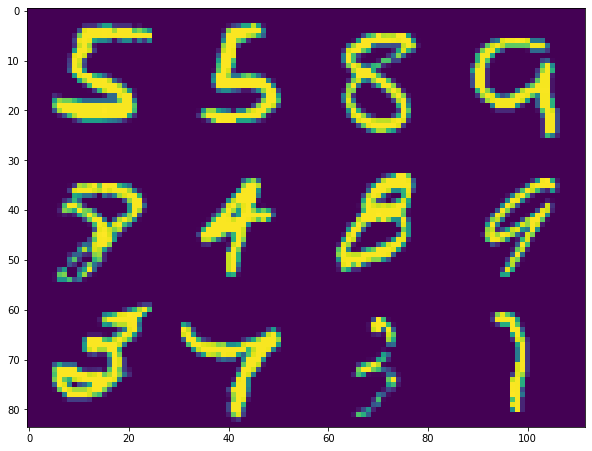

In [48]:
def vis_same_error(y_test_t, pred)-> None:

    idx = np.argwhere(y_test_t.data != pred)
    bad = x_test[idx]  
    tmp = []
    for _ in range(12):
        tmp.append(np.random.randint(bad.shape[0]))
    
    figsize(10, 10)
    imshow(np.concatenate(bad[tmp].reshape(4, 28*3, 28), axis = 1))
    print('')
    print('Predicted: ', pred[idx][tmp].ravel(), 'Target', y_test_t.data[idx][tmp].ravel())


def evaluate(model, x, y)-> None:
    y_= model.forward(x)
    # print(y_.data.shape)
    pred =  np.argmax(y_.data, axis =1)
    acc = (y.data == pred).mean()
    print('Accuracy model: ', acc)
    print('Bad count: ', int(y.data.shape[0] * (1 - acc)))
    vis_same_error(y_test_t, pred)


x_test_t = Tensor(x_test.reshape(-1, 28*28))
y_test_t = Tensor(y_test)
evaluate(model, x_test_t, y_test_t)

TODO

- make cov
- make adam
-